# Airbnb Boston and Seattle Data Analysis

This notebook provides you with all the details about the Boston and Seattle data analysis project, including data collection, cleaning, manipulation, analysis, visualization, and brief explanations. This analysis is purely exploratory and does not include any machine learning modeling.

## Section 1: Business Understanding

First, in this section, I list 3 business problems that I want to solve in this project.
- <strong>Question 1: Can you describe the vibe of each Boston/Seattle neighborhood using listing descriptions?</strong>
- <strong>Question 2: What are the busiest times of the year to visit Boston/Seattle? By how much do prices spike?</strong>
- <strong>Question 3: Is there a general upward trend of new Airbnb listings to Boston/Seattle?</strong>

Before we get started, let's load all the required python modules.

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import calendar
%matplotlib inline

## Section 2: Data Understanding

### Gather Data

Boston airbnb and Seattle airbnb data can be downloaded from the following two websites:
- https://www.kaggle.com/datasets/airbnb/boston?resource=download
- https://www.kaggle.com/datasets/airbnb/seattle?select=reviews.csv

They each contain three data files: `listings.csv` contains all the details of the listing on a particular snapshot date; `calendar.csv` contains daily availability and listing prices for a calendar year; `reviews.csv` contains customer reviews from time to time across many years. In the next code block, I imported all three dataframes for Boston and Seattle respectively, but I will only use `listings.csv` and `calendar.csv` for subsequent analysis.

In [111]:
# Read in Boston data
calendar_boston = pd.read_csv('Boston_data/calendar.csv')
listings_boston = pd.read_csv('Boston_data/listings.csv')
reviews_boston = pd.read_csv('Boston_data/reviews.csv')

# Read in Seattle data
calendar_seattle = pd.read_csv('Seattle_data/calendar.csv')
listings_seattle = pd.read_csv('Seattle_data/listings.csv')
reviews_seattle = pd.read_csv('Seattle_data/reviews.csv')

## Section 3: Data Preparation

### Clean Data

To address the first question, I would like to explore the relationship between listing price and neighborhood. However, the `price` column is of type string and has a `$` sign before the numerical value I need. So the first thing I did was remove the `$` sign. 

Then in preparation for later analysis and visualization, I sorted all neighborhoods in descending order of median listing price in that area.

In [112]:
def get_sorted_data(df):
    """
    Get listings with sorted neighbourhood by median price in descending order
    
    Input:
      df: original listings data from Boston or Seattle
      
    Output:
      df_sorted: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      sorted_neighbors_values: array of sorted median prices
    """
    # Remove the $ sign in the price column and save as new column "price_value"
    df["price_value"] = pd.to_numeric(df.price.str[1:], errors='coerce')
    
    # Sort "neighborhood_cleased" column in descending order of the calculated median "price_values",
    # with the sorted index saved to sorted_neighbors and sorted values saved to sorted_neighbors
    sorted_neighbors = df.groupby("neighbourhood_cleansed").median()["price_value"].sort_values(ascending=False).index
    sorted_neighbors_values = df.groupby("neighbourhood_cleansed").median()["price_value"].sort_values(ascending=False).values

    # Re-arrange the dataframe with sorted neighborhoods
    df_sorted = pd.DataFrame()
    for neighbor in sorted_neighbors:
        df_sorted = pd.concat([df_sorted, df.loc[df.neighbourhood_cleansed == neighbor, :]], axis=0)
    
    return df_sorted, sorted_neighbors, sorted_neighbors_values

I then called the `get_sorted_data` functions and obtained sorted Boston and Seattle dataframes, along with the indices and values of the sorted neighborhoods. I further checked how many neighborhoods exist in both datasets.

In [113]:
df_boston, sorted_neighbors_boston, sorted_neighbors_values_boston = get_sorted_data(listings_boston)
len(sorted_neighbors_boston)

25

There are 25 neighborhoods in Boston Airbnb data.

In [114]:
df_seattle, sorted_neighbors_seattle, sorted_neighbors_values_seattle = get_sorted_data(listings_seattle)
len(sorted_neighbors_seattle)

87

There sre 87 neighborhoods in Seattle Airbnb data.

Also, to solve the second problem, I utilized the `calendar` module to first extract the numeric months from the `date` column in the format 'mm/dd/yyyy' and save as column `month_numbers`, then converted the numeric months to abbreviations and save as column `month_abbrs`.

In [115]:
# Extract numeric month from the date column with format 'mm/dd/yyyy' and save as column 'month_numbers'
calendar_boston["month_numbers"] = [int(ele.lstrip('0')) for ele in calendar_boston.date.str[5:7]]
calendar_seattle["month_numbers"] = [int(ele.lstrip('0')) for ele in calendar_seattle.date.str[5:7]]

# Transform numeric month to abbreviations and save as column 'month_abbrs'
calendar_boston["month_abbrs"] = [calendar.month_abbr[month_number] for month_number in calendar_boston["month_numbers"]]
calendar_seattle["month_abbrs"] = [calendar.month_abbr[month_number] for month_number in calendar_seattle["month_numbers"]]

## Section 4: Evaluate the Results

### Question 1: Can you describe the vibe of each Boston/Seattle neighborhood using listing descriptions?

I want to explore the neighborhood context of these two cities by analyzing three relationships:
1. Check listing prices by neighbourhood, with neighbourhood sorted by median price in descending order
2. Examine how the median price is affected by the percentage of the entire house/apartment
3. Check the percentage of property type by neighbourhood

The logic for checking median prices is because sometimes listing prices are highly correlated with real estate prices, which will determine how affluent an area is. Wealthier areas are always associated with safer and better neighborhoods. Also, I suspect the listing price is heavily dependent on the percentage of the entire house/apartment. So this is another thing I need to check. Finally, I'll explore the distribution of property types in different neighborhoods.

#### Analyze

To examine the listing prices by neighborhood, I generated boxplot with neighborhoods sorted by median price in descending order. The reason I use the `neighbourhood_cleansed` column is because the column does not contain any missing values, and from its name "cleansed" it appears that the column has been cleaned/imputed before. There are also no missing values in the `price_value` column. Therefore, we can safely skip the missing data handling step.

#### Visualize

Following are the definitions of the plotting functions. The boxplot function is `boxplot_neighbor_vs_medianPrice`, which calls the `add_n_obs` function to add observations to the plot which is used for answering sub question 1. The scatter plot function is `scatterplot_percentageEntireHome_vs_medianPrice` for sub questions 2, and the stacked bar plot function is `stackedbarplot_percentagePropertyTypes_vs_neighbourhood` which is for sub question 3.

In [116]:
def add_n_obs(plt, df, sorted_neighbors, group_col, y, textPos=600):
    '''
    Add N Obs on the price vs. neighborhood boxplot
    
    Input:
      plt: current plot handle on which numbers of observations are to be added
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      group_col: categorical groups for the boxplot
      y: continuous variable for the boxplot
      textPos: The Y axis positions to add numbers of observations
      
    Output:
      None
    '''
    yticklabels = [y.get_text() for y in plt.gca().get_yticklabels()]
    n_obs = df.groupby(group_col)[y].size().loc[sorted_neighbors]
    for (y, yticklabel), n_ob in zip(enumerate(yticklabels), n_obs):
        plt.text(textPos, y, "#obs: "+str(n_ob), verticalalignment='center', fontdict={'size':14}, color='red')
        

def boxplot_neighbor_vs_medianPrice(df, sorted_neighbors, title, width, height):
    '''
    Generate boxplot of price by neighbourhood, with neighbourhood in descending order of median price
    
    Input:
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      title: plot title
      width: plot width
      height: plot height
      
    Output:
      None
    '''
    plt.figure(figsize=(width, height))
    sns.set_style("whitegrid")
    sns.boxplot(x='price_value', y='neighbourhood_cleansed', data=df, orient="h")
    add_n_obs(plt, df, sorted_neighbors, group_col='neighbourhood_cleansed', y='price_value', textPos=600)
    plt.title(title, fontsize=16)

    
def scatterplot_percentageEntireHome_vs_medianPrice(df, sorted_neighbors, sorted_neighbors_values, title):
    '''
    Generate scatterplot of median price vs. percentage of entire home/apt
    
    Input:
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      sorted_neighbors_values: array of sorted median prices
      title: plot title
      
    Output:
      None. Only Spearman correlation is printed on the screen
    '''
    percentage_entire_home = []
    for col in sorted_neighbors:
        tbl = df[df.neighbourhood_cleansed == col].room_type.value_counts()
        percentage_entire_home.append(round(tbl["Entire home/apt"]/tbl.sum() * 100, 2))
    
    df = pd.DataFrame({
        'sorted_neighbors_values': sorted_neighbors_values,
        'percentage_entire_room': percentage_entire_home
    })
    sns.lmplot(x="sorted_neighbors_values", y="percentage_entire_room", data=df)
    spearman_rho = round(df.corr(method="spearman").loc['percentage_entire_room', 'sorted_neighbors_values'], 2)
    plt.xlabel('Median Neighboring Price')
    plt.ylabel('Percentge of Entire Home/Apt in All Room Type')
    plt.suptitle(title, y=1.08, fontsize=14)
    plt.title('Spearman Correlation = ' + str(spearman_rho), fontsize=12)
    

def stackedbarplot_percentagePropertyTypes_vs_neighbourhood(df, sorted_neighbors, title, width, height):
    '''
    Generate stacked bar plot of percentage of property type by neighbourhood
    
    Input:
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      title: plot title
      width: plot width
      height: plot height
      
    Output:
      None
    '''
    df['temp_value'] = 1
    df = df[['neighbourhood_cleansed', 'property_type', 'temp_value']]
    df_wide = df.pivot_table(index='neighbourhood_cleansed', columns='property_type', values='temp_value', aggfunc = 'sum', fill_value = 0)
    df_wide = df_wide.apply(lambda x: x / x.sum() * 100, axis=1).loc[sorted_neighbors, :]

    df_wide.plot(kind="bar", stacked=True, figsize=(width,height))
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(title, fontsize=16)

With the above functions, I generate boxplots of price by neighborhood for Boston and Seattle data, respectively:

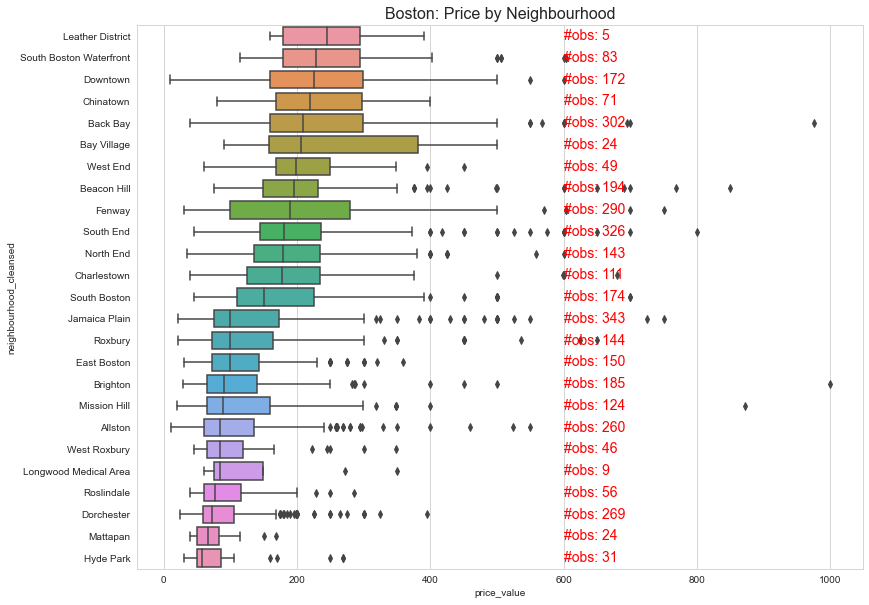

In [117]:
boxplot_neighbor_vs_medianPrice(df_boston, sorted_neighbors_boston,
                                title="Boston: Price by Neighbourhood", width=13, height=10)

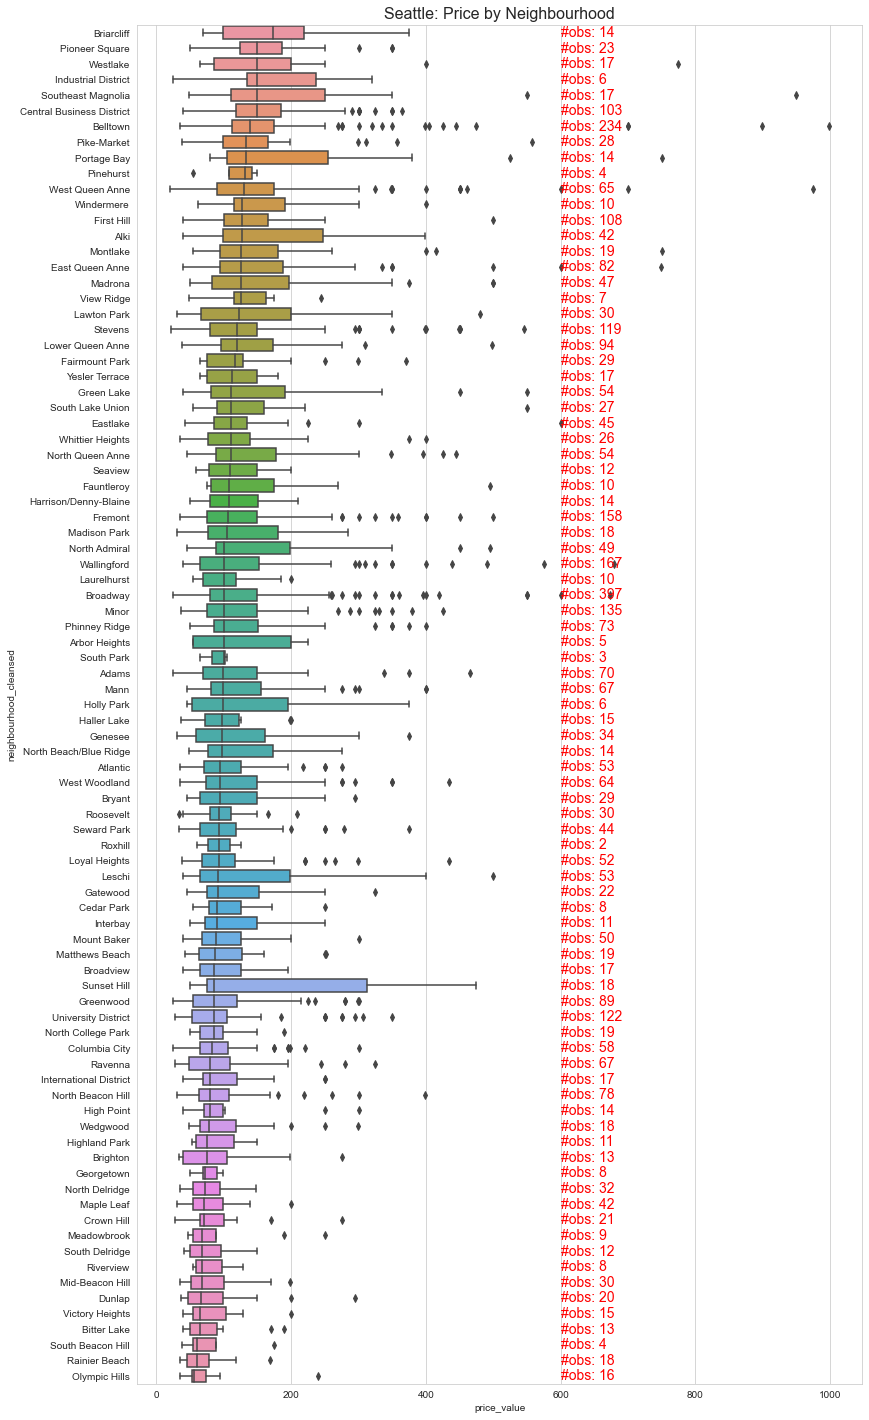

In [118]:
boxplot_neighbor_vs_medianPrice(df_seattle, sorted_neighbors_seattle,
                                title="Seattle: Price by Neighbourhood", width=13, height=25)

I used the following scatter plots below to demonstrate the relationship of median price vs. percentage of entire home/apt.

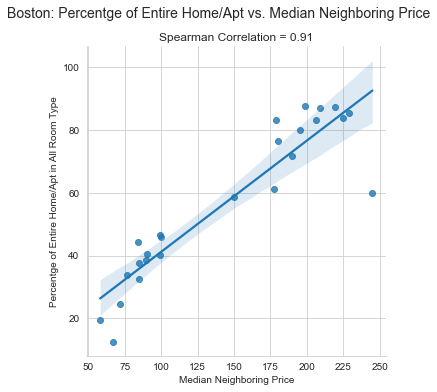

In [119]:
scatterplot_percentageEntireHome_vs_medianPrice(df_boston, sorted_neighbors_boston, sorted_neighbors_values_boston,
                                                title='Boston: Percentge of Entire Home/Apt vs. Median Neighboring Price')

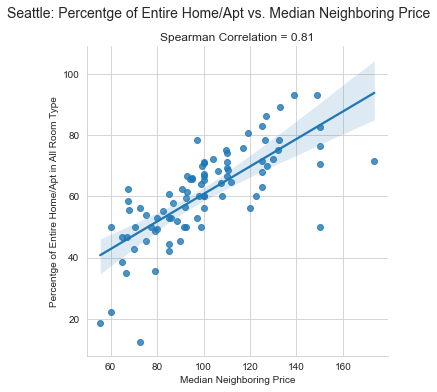

In [120]:
scatterplot_percentageEntireHome_vs_medianPrice(df_seattle, sorted_neighbors_seattle, sorted_neighbors_values_seattle,
                                                title='Seattle: Percentge of Entire Home/Apt vs. Median Neighboring Price')

Finally, I generated stacked bar plots of percentage of property type by neighbourhood:

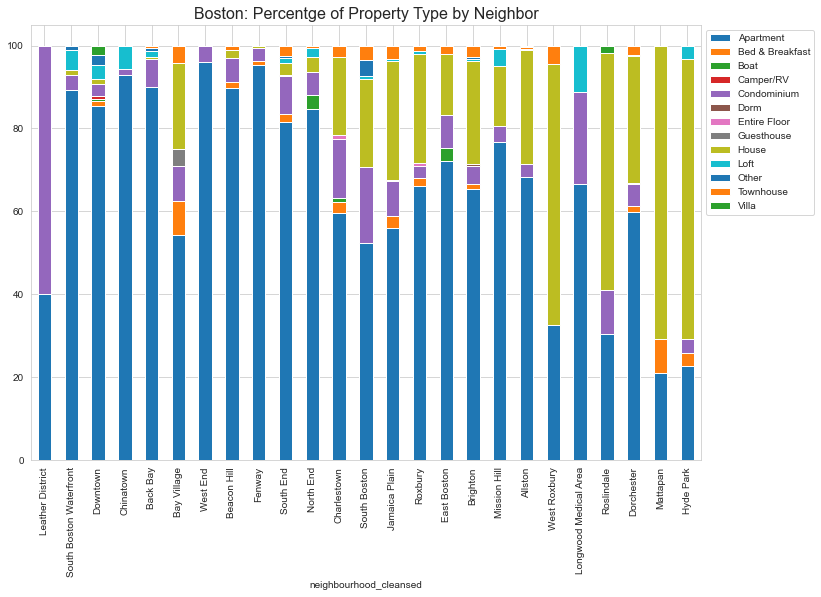

In [121]:
stackedbarplot_percentagePropertyTypes_vs_neighbourhood(df_boston, sorted_neighbors_boston,
                                                       title='Boston: Percentge of Property Type by Neighbor',
                                                       width=12, height=8)

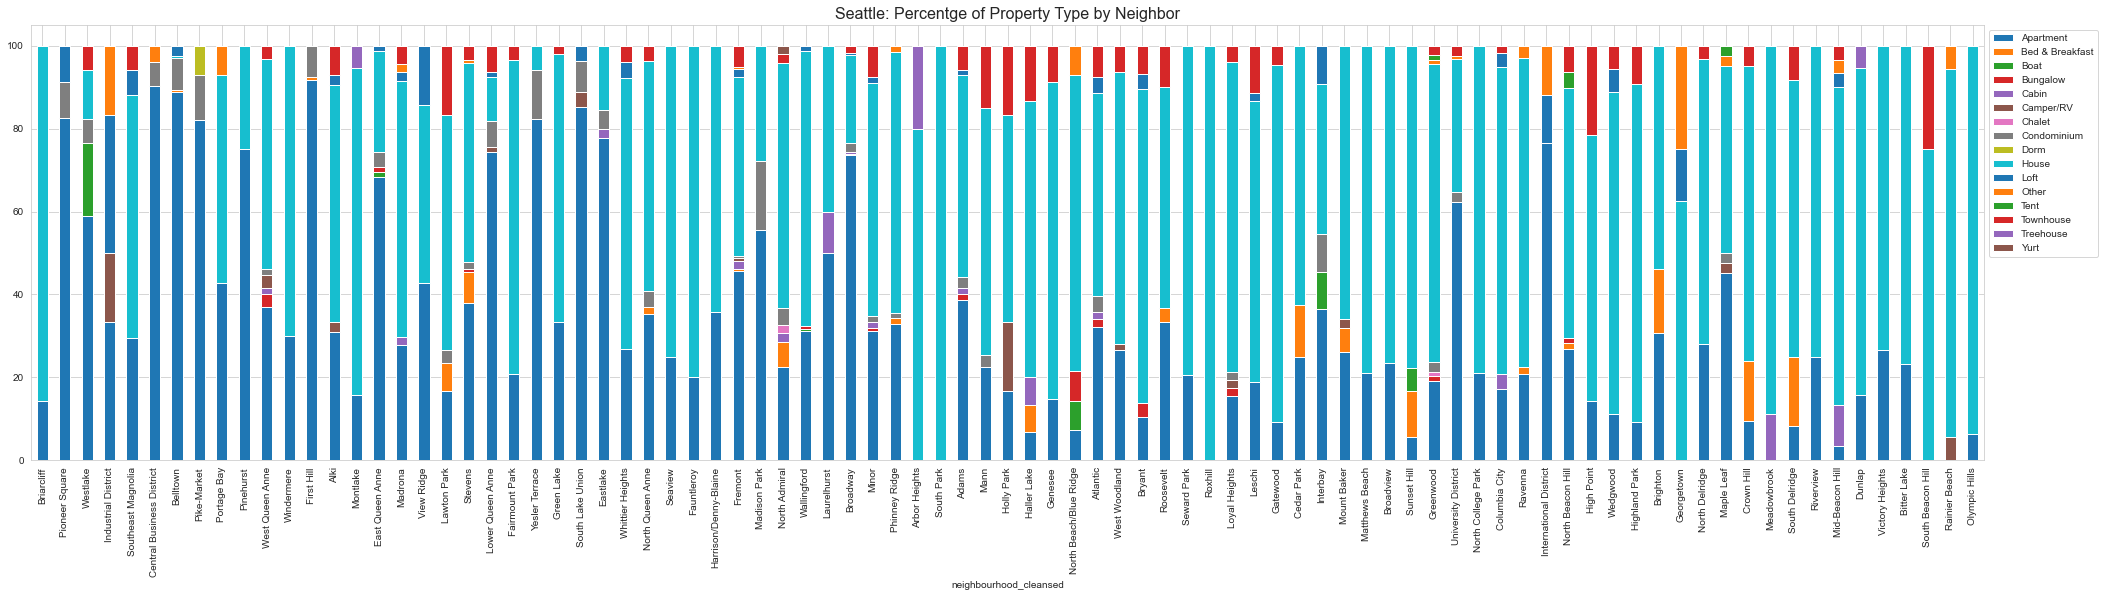

In [122]:
stackedbarplot_percentagePropertyTypes_vs_neighbourhood(df_seattle, sorted_neighbors_seattle,
                                                       title='Seattle: Percentge of Property Type by Neighbor',
                                                       width=35, height=8)

#### Brief explanation for visualization

According to Boston Airbnb boxplot, the top 5 neighborhoods in terms of median listing price are:
- Leather District
- South Boston Waterfront
- Downtown
- Chinatown
- Back Bay

While the bottom 5 Boston neighborhoods are:
- Longwood Medical Area
- Roslindale
- Dorchester
- Mattapan
- Hyde Park

Similarly, according to Seattle Airbnb data which has 3,818 listings in total, the top 5 neighborhoods in terms of median listing price are:
- Briarcliff
- Pioneer Square
- Westlake
- Industrial District
- Southeast Magnolia

While the bottom 5 Seattle neighborhoods are:
- Victory Heights
- Bitter Lake
- South Beacon Hill
- Rainer Beach
- Olympic Hills

However, the Seattle neighborhoods are too finely divided, and the median prices in different neighborhoods are not as pronounced as those in different Boston neighborhoods.

From the scatter plot of the median price in the neighborhood versus the percentage of the entire home/apartment, it does show a relationship. For the Boston data, the Spearman correlation is as high as 0.91, and for the Seattle data, the Spearman correlation is still as high as 0.81.

Additionally, I checked the property types of neighbors in Boston and Seattle, respectively. From Boston’s data, I’ve observed an interesting trend that the top neighbors mostly own ‘condo/apartment’ type properties. That doesn’t seem to be the case with Seattle’s data: The ‘house’ type of properties has the highest percentage of nearly all neighborhoods.

### Question 2: What are the busiest times of the year to visit Boston/Seattle? By how much do prices spike?

#### Analyze

I used one year of calendar data to answer this question. From January to December of the year, we summarized the total number of available listings and the median price for each month. For any missing value in `price_value`, I filled the value with 0 so that we could finally calculate the sum or median and other non-missing values.

#### Visualize

Following are the definitions of the plotting functions. `barplot_percentageAvailability_vs_month` is used to plot the percentage of listings listed by month, and `lineplot_price_vs_month` is used to plot a line graph of the corresponding listing price. The two result plots will be placed side-by-side to see how listing availability and prices will change with the different times of the year, and if they change at the same time.

In [123]:
sorted_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def barplot_percentageAvailability_vs_month(df, title, width, height, color):
    '''
    Generate bar plot of percentage of availability by month
    
    Input:
      df: preprocessed calendar dataframe from Boston or Seattle
      title: plot title
      width: plot width
      height: plot height
      color: bar color
      
    Output:
      None
    '''
    df['temp_value'] = 1
    df = df[['month_abbrs', 'available', 'temp_value']]
    df_wide = df.pivot_table(index='month_abbrs', columns='available', values='temp_value', aggfunc = 'sum', fill_value = 0)
    df_wide = df_wide.apply(lambda x: x / x.sum() * 100, axis=1).loc[sorted_months, 't']
    df_wide.plot(kind="bar", color=color, figsize=(width,height))
    plt.title(title, fontsize=16)

def lineplot_price_vs_month(df, title, width, height, color):
    '''
    Generate line plot of median listing price by month
    
    Input:
      df: preprocessed calendar dataframe from Boston or Seattle with listings available
      title: plot title
      width: plot width
      height: plot height
      color: line color
      
    Output:
      None
    '''
    df = df.copy()
    df["price_value"] = pd.to_numeric(df.price.str[1:], errors='coerce')
    df = df[['month_abbrs', 'available', 'price_value']]
    df_wide = df.pivot_table(index='month_abbrs', columns='available', values='price_value', aggfunc = 'median', fill_value = 0)
    df_wide = df_wide.loc[sorted_months, :]
    df_wide.plot(kind="line", color=color, figsize=(width,height))
    plt.title(title, fontsize=16)
    plt.legend('')

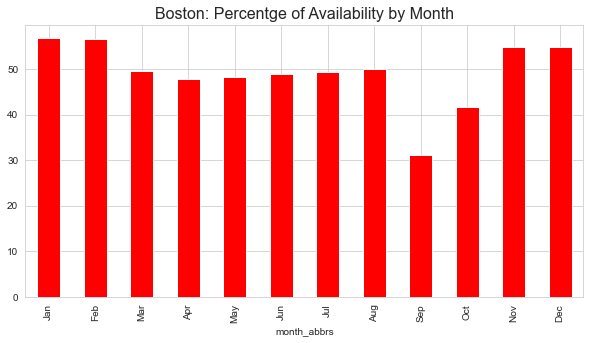

In [124]:
barplot_percentageAvailability_vs_month(calendar_boston, 
                                        title='Boston: Percentge of Availability by Month', width=10, height=5, color='red')

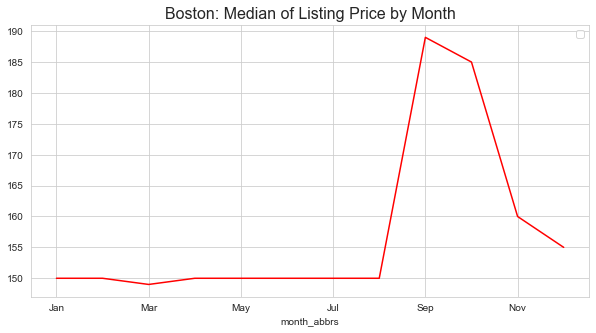

In [125]:
lineplot_price_vs_month(calendar_boston[calendar_boston.available == 't'],
                        title='Boston: Median of Listing Price by Month', width=10, height=5, color='red')

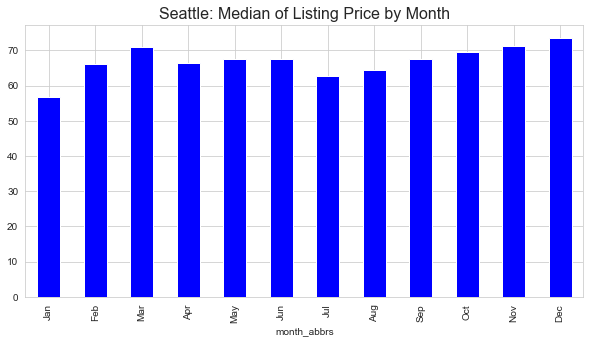

In [126]:
barplot_percentageAvailability_vs_month(calendar_seattle, 
                                        title='Seattle: Median of Listing Price by Month', width=10, height=5, color='blue')

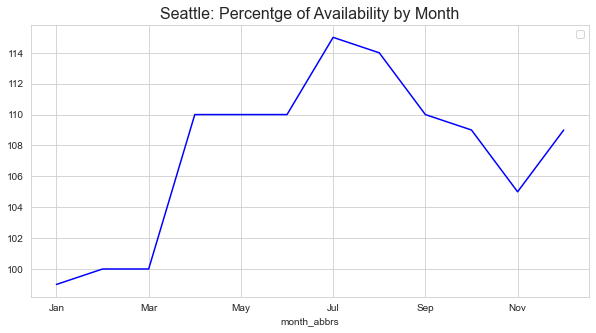

In [127]:
lineplot_price_vs_month(calendar_seattle[calendar_seattle.available == 't'],
                        title='Seattle: Percentge of Availability by Month', width=10, height=5, color='blue')

#### Brief explanation for visualization

We can see that in Boston, September is the busiest time of the year for tourists, while the period from November to February is the least busy. As availability dwindles, prices start to spike, and vice versa. In September, the busiest month, the median price was close to ``$190`` as only 32% of listings were available for booking, and prices fell to `$150`-`$160` as the availability percentage increased to 50%.

In Seattle, by contrast, January are July are the busiest times of the year for tourists, and other times of the year are less busy. March and December are the least busy. However, January also had the lowest median price, which I can’t explain. I highly suspect that the data for January is incomplete for some reason, so conclusions about January being the busiest time of the year may not be reliable. In other months, I can still observe the same trend as Boston, such as in July, when supply dwindles and prices spike.

### Question 3: Is there a general upward trend of new Airbnb listings to Boston/Seattle?

#### Analyze

To address this question I used the listings data which I used for Question 1. There is a column called `host_since_year` that seems to reflect the starting year of the listings, which luckily doesn't contain any missing values. I then generated line plots for the Boston and Seattle data. For comparison, I plotted the two lines together in one figure.

#### Visualize

In this part we only have one function `lineplot_newListings` for which we plot two dataframes in one figure. 

In [128]:
def lineplot_newListings(df1, df2, title):
    '''
    Generate line plot for number of new listings by month
    
    Input:
      df1: 1st listing dataframe (Boston data)
      df2: 2nd listing dataframe (Seattle adata)
      title: plot title
      
    Output:
      None
    '''
    df1['host_since_year'] = [ele for ele in df1.host_since.str[0:4]]
    df2['host_since_year'] = [ele for ele in df2.host_since.str[0:4]]
    values1 = df1['host_since_year'].value_counts().loc[::-1]
    values2 = df2['host_since_year'].value_counts().loc[::-1]
    plt.figure(figsize=(8,5))
    plt.plot(values1.sort_index(), label='Boston', color='red')
    plt.plot(values2.sort_index(), label='Seattle', color='blue')
    plt.legend()
    plt.title(title)

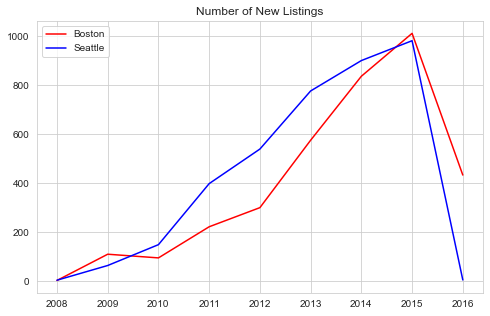

In [129]:
lineplot_newListings(listings_boston, listings_seattle, 'Number of New Listings')

#### Brief explanation for visualization

From the above line plot I observe similar trends that New Airbnb listings are generally on the rise in the Boston and Seattle areas. In fact, the number of Airbnb listings in both regions exploded from 2008 to 2015. Except for 2016, the number of listings is low, probably because the data for 2016 was still being collected when this dataset was published, so the data for 2016 is rather incomplete.